In [2]:
import xarray as xr
from netCDF4 import Dataset
import pydap as dap
import numpy as np
import sklearn.cluster as cl
from eofs.xarray import Eof
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.cm import get_cmap
import cartopy.crs as ccrs
import cartopy.feature
from PlotContourQuiver import *
from paraguayfloodspy.weather_type import XrEofCluster 
%matplotlib inline

See weather type codes at https://github.com/jdossgollin/paraguayfloodspy/blob/master/paraguayfloodspy/weather_type.py
[Package used in Doss-Gollin et al (to be submitted), coded by James Doss-Gollin and Ángel G. Muñoz]

## Make WT
Downloading latest model data (re-forecast)

In [22]:
# !rm -Rf hgt_ecmwf_ctrl.nc hgt_ecmwf_prtb.nc
# !curl -k -b '__dlauth_id=017a28e8531cac13efd89be8a7612c4c0754a83606f8f90270d14d84f62c28d7ff7fe8fbfb04c0495ddf938392d0bf3d9617e8b7' 'https://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.ECMF/.reforecast/.control/.pressure_level_gh/.gh/P/500/VALUE/P/removeGRID/S/(last)/VALUE/S/removeGRID/hdate/(1997)/(2016)/RANGE/X/(-150)/(-50)/RANGE/Y/(20)/(80)/RANGE/data.nc' >hgt_ecmwf_ctrl.nc
#!curl -k -b '__dlauth_id=017a28e8531cac13efd89be8a7612c4c0754a83606f8f90270d14d84f62c28d7ff7fe8fbfb04c0495ddf938392d0bf3d9617e8b7' 'https://iridl.ldeo.columbia.edu/SOURCES/.ECMWF/.S2S/.ECMF/.reforecast/.perturbed/.pressure_level_gh/.gh/P/500/VALUE/P/removeGRID/S/(last)/VALUE/hdate/(1997)/(2016)/RANGE/X/(-150)/(-50)/RANGE/Y/(20)/(80)/RANGE/S/removeGRID/data.nc' >hgt_ecmwf_prtb.nc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  102M  100  102M    0     0   492k      0  0:03:33  0:03:33 --:--:-- 13.7M--:--:--  0:01:42 --:--:--     00 --:--:--  0:02:28 --:--:--     0


In [3]:
hgt = xr.open_dataset('./hgt_ecmwf_prtb.nc',decode_times=False)
hgt=hgt.stack(time=('hdate', 'L')).T   #trick to deal with the time coordinates
hgt=hgt-np.mean(hgt,0)  #anomalies
hgt

<xarray.Dataset>
Dimensions:  (M: 10, X: 68, Y: 42, time: 940)
Coordinates:
  * M        (M) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0
  * X        (X) float64 -150.0 -148.5 -147.0 -145.5 -144.0 -142.5 -141.0 ...
  * Y        (Y) float64 19.5 21.0 22.5 24.0 25.5 27.0 28.5 30.0 31.5 33.0 ...
  * time     (time) MultiIndex
  - hdate    (time) float64 450.0 450.0 450.0 450.0 450.0 450.0 450.0 450.0 ...
  - L        (time) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 ...
Data variables:
    gh       (time, X, Y, M) float64 7.462 1.393 4.486 8.736 7.599 2.82 ...

In [24]:
print(hgt['time'])

<xarray.DataArray 'time' (time: 940)>
array([(450.0, 0.0), (450.0, 1.0), (450.0, 2.0), ..., (678.0, 44.0),
       (678.0, 45.0), (678.0, 46.0)], dtype=object)
Coordinates:
  * time     (time) MultiIndex
  - hdate    (time) float64 450.0 450.0 450.0 450.0 450.0 450.0 450.0 450.0 ...
  - L        (time) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 ...


For reproducibility, random seed:

In [25]:
np.random.seed(123)
best_centroid, best_ts, classifiability = XrEofCluster(
    hgt,
    n_clusters=4,
    prop=0.8, # What proportion of variance should be retained?
    nsim=100, # How many random initializations to compute?
    pcscaling=0, # If 0: PCs are unscaled. If 1: all are rescaled
    variable='gh', # the variable name of hgt
    verbose = True # get useful info from the algorithm
)

xarray-based classifiability for 4 clusters
Performing EOF decomposition of data for dimension reduction...
Number of EOFs retained is 68
Carrying out 100 k-means simulations...
Computing classifiability index for each pair of simulations...


In [26]:
best_ts = np.int_(best_ts) # make it an integer

In [27]:
print(classifiability)

0.588893047716


## Plot WTs

I think this code is helpful because it automates some of the tedious parts of plotting with subplots https://github.com/jdossgollin/paraguayfloodspy/blob/master/paraguayfloodspy/visualize.py

In [8]:
import paraguayfloodspy.visualize as viz

When we loop through we'll use this function to grab all data from a particular weather type

In [9]:
def selector(ds, wt):
    # get the days of the particular weather type
    idx = np.where(best_ts==wt)[0]
    ds = ds.isel(time=idx)
    ds = ds.mean(dim = 'time')
    return(ds)

For example:

In [10]:
#selector(hgt['gh'], wt=1)

Now set up the plot

In [11]:
wt_all = np.unique(best_ts)
n_wt = len(wt_all)
clusters = np.sort(np.unique(best_ts))
prop_days = [np.mean(best_ts==i) for i in clusters]
n_cols=1
X,Y = np.meshgrid(hgt.X, hgt.Y)

And actually build the plot

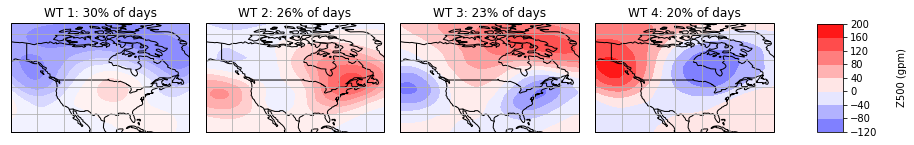

In [21]:
# Create Axes
fig, axes = viz.SetupAxes(ncol=n_wt, nax=n_cols, proj = ccrs.PlateCarree(), figsize = [12, 15])
#fig, axes = viz.SetupAxes(ncol=n_cols, nax=n_wt, proj = ccrs.Orthographic(-80, 35), figsize = [12, 8])
#fig, axes = viz.SetupAxes(ncol=n_cols, nax=n_wt, proj = ccrs.LambertConformal(-80, 35), figsize = [12, 8])

# Add the data to the plots
for i,wt in enumerate(wt_all):
    sub = selector(hgt['gh'], wt=wt)
    ax = viz.GetRowCol(i, axes)
    #C0 = ax.pcolormesh(X,Y, sub.values.T, transform=ccrs.PlateCarree(), vmin=5000, vmax=6000)
    C0 = ax.contourf(X,Y, sub.values.T, transform=ccrs.PlateCarree(), vmin=-200, vmax=200, cmap='bwr')
    ax.set_title('WT {}: {:.0%} of days'.format(i+1, prop_days[i]))

# Add things to the plot (can also use viz.FormatAxes)
for ax in axes.flat:
    ax.add_feature(cartopy.feature.BORDERS)
    ax.coastlines()
    ax.gridlines()

# Add Colorbar
fig.tight_layout()
fig.subplots_adjust(right=0.9)
#cax0 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cax0 = fig.add_axes([0.95, 0.45, 0.03, 0.1])   #xpos,ypos, barwidth, barheight
cbar0 = fig.colorbar(C0, cax = cax0)
cbar0.set_label('Z500 (gpm)', rotation=90)
cbar0.ax.get_yaxis().labelpad = 20

In [28]:
best_ts

array([4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 3, 2, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 2, 2, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 4, 4, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 4, 4, 4, 3, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 2, 4, 4, 3, 3, 3, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 3, 3, 3, 3, 3, 3,
       4, 4,

In [15]:
pepe=hgt.isel(M=0)

In [16]:
pepe

<xarray.Dataset>
Dimensions:  (X: 68, Y: 42, time: 940)
Coordinates:
    M        float64 1.0
  * X        (X) float64 -150.0 -148.5 -147.0 -145.5 -144.0 -142.5 -141.0 ...
  * Y        (Y) float64 19.5 21.0 22.5 24.0 25.5 27.0 28.5 30.0 31.5 33.0 ...
  * time     (time) MultiIndex
  - hdate    (time) float64 450.0 450.0 450.0 450.0 450.0 450.0 450.0 450.0 ...
  - L        (time) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 ...
Data variables:
    gh       (time, X, Y) float64 7.462 -6.473 -22.8 -40.63 -54.14 -64.34 ...